## Question 2 - Basic Bidding Strategies

### Import Libraries

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import time
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import MultiLabelBinarizer
from random import randrange

pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows",999)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [2]:
def memory(df):
    print("Memory usage of the dataframe is {:.2f} MB".format(
        df.memory_usage().sum() / 1024**2))

In [3]:
convert = True
path = 'C:/Users/User/OneDrive/UCL/term_2/git/maai_bid_strategy'

if(convert):
    train_df = pd.read_csv(path+'/we_data/train.csv')
    train_df.to_hdf('train.h5', 'train')
    
else:
    train_df = pd.read_hdf('train.h5', 'train')
    
memory(train_df)

Memory usage of the dataframe is 463.67 MB


In [4]:
convert = True
path = 'C:/Users/User/OneDrive/UCL/term_2/git/maai_bid_strategy'

if(convert):
    val_df = pd.read_csv(path+'/we_data/validation.csv')
    val_df.to_hdf('validation.h5', 'validation')
    
else:
    val_df = pd.read_hdf('validation.h5', 'validation')
    
memory(val_df)

Memory usage of the dataframe is 57.97 MB


In [4]:
val_df.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,4,20,bbcb813b6166538503d8b33a5602d7d72f6019dc,663169f66491c98c69f1f94a5c48fa34aa9fe06f,windows_ie,211.144.203.*,79,79,1.0,trqRTvFRLpscFU,5ede68cc7542a34777fb8a1574856b6f,NaN,mm_10027070_2459574_9659312,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,23,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10111"
1,0,1,21,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,a23f0cfab6592c137f796e68fa752fceba08bb1b,windows_chrome,58.247.250.*,79,79,1.0,trqRTu1YP5scFsf,cff326604db401e7d4f895fd747f7e91,NaN,mm_10075660_3500949_11453278,950,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,75,a3becb967c015e9acb5e72f22b100ef8,3476,"10075,10057,10024,10052,10083,10063,10006,10110"
2,0,4,8,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,5105a013ea54a9706146033e6a138d5234a3803e,windows_ie,117.12.111.*,2,2,2.0,trqRTv14MqTR1m58uG,93f242f025dc7d424c4ba7002b177df7,NaN,2996225656,300,250,2,0,5,911b2d84826786018761e8c0b0a3a60c,238,65,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10024,10059,10063,13776,10083,10006,10111"
3,0,5,15,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,577e9a768ce17e73c61ba7022db927f9ee761830,windows_chrome,61.187.224.*,201,205,2.0,trqRTvdJMoFoFoc4JKn,40c388f45dbc0e1fc53a8c6c81305de5,NaN,3481684581,336,280,2,0,5,dc0998c10f8f0b623b5d949e8272e4c7,238,6,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10057,10006,10063,10110"
4,0,1,18,0899bf144249458ea9c89188473694bf44c7ca15,e4bf79c562745d671b19f2edf7fda89c2e25987f,windows_chrome,117.41.145.*,134,135,2.0,tKFJeun0BouoXOl4JKTI,fcf53e0e5f09aa8d7e1c9d986cea321,NaN,1120607322,200,200,1,0,5,23485fcd23122d755d38f8c89d46ca56,249,5,7e0e909ea89f707bc20f9585c9072081,3476,"10006,10063,13776,10110"


In [30]:
val_df.shape

(303925, 25)

In [23]:
a = val_df[(val_df.click == 1) & (val_df.payprice < 20)]
a

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
13226,1,2,16,8d709ab374548e9e812c02147307c32aa7b3d8de,4a4dd1c3e7e890a6fbfcfa0e0ddd738b53362087,android_safari,14.223.74.*,216,222,NaN,NaN,NaN,NaN,1,320,50,FirstView,Na,6,11908,277,6,NaN,2997,NaN
42362,1,6,21,2b6f5cc9e5f34adf795986ffacfe2f0bcd3292e5,3168a396ef2dbfabf3e819dbe6aedf69d2ad5a8e,windows_ie,113.250.182.*,275,275,2.0,tSK-txxoMNj7JOTfUDaWN6q8,2865a7c798c5140ea6985a8b05c9a072,NaN,1021056699,468,60,1,0,5,612599432d200b093719dd1f372f7a30,300,15,bebefa5efe83beee17a3d245e7c5085b,1458,"13800,10057"
116879,1,0,18,ab86ee0469d7a0cbc2b687475a86be694adb6cbc,c1af651fdf43418231f57a62e0af2813e9812402,windows_chrome,113.200.136.*,333,334,2.0,DFpETuMYXxscFU,f81b0591a56530db2c8ec9f102c5021f,NaN,303510054,728,90,2,0,5,4b724cd63dfb905ebcd54e64572c646d,238,12,b2e35064f3549d447edbbdfb1f707c8c,3427,"10048,10074,10006,10075,10024,10083,13866,1006..."
172066,1,2,13,e02f5f3a3f46479f85a6dcc3478800836b581767,6a77023e6783777f85fec619fd2761b76dfa8db3,windows_chrome,121.9.144.*,216,222,2.0,trqRTJn7O95I1mKYUV,57bebe4ef4aa03a4489d0396a5b5d34c,NaN,3941545033,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,18,0f951a030abdaedd733ee8d114ce2944,3427,"13866,13042,10006,10110"
180149,1,5,5,7b864b7ccad185c6bc544c1d1e16bdfea33e678a,e77835c3df471817ad0720adb86a831fcdf3d1f4,windows_ie,123.172.236.*,55,60,3.0,DDTSQuf0MTTNaqKIvMpENpn,57f1712646e702b9fbb121b9edf64c90,NaN,Astro_F_Rectangle,300,250,0,0,10,a499988a822facd86dd0e8e4ffef8532,300,16,bebefa5efe83beee17a3d245e7c5085b,1458,"10077,11278,10083,10059,10111"
231614,1,2,17,2367fc238d6d86d86431e95b228625ad8910b2a0,1f6a6944c3ef6f5eac9a1158ccc53e191cea42cc,android_safari,221.125.128.*,394,394,NaN,NaN,NaN,NaN,1,320,50,FirstView,Na,6,11908,277,6,NaN,2997,NaN
263502,1,2,18,e96813a2fc8489af1c7b74d2bb2d7125f9c8b59b,aeb463700e3c109b32cf626b3ee71e1c9f948674,android_safari,115.62.155.*,164,169,NaN,NaN,NaN,NaN,1,320,50,FirstView,Na,6,11908,277,6,NaN,2997,NaN
281226,1,4,23,56866c49459302749e500d9898e0b933185a62c6,464be42ea428c4e9cabe60b07318776bd9c3210b,windows_ie,221.213.12.*,308,309,1.0,trqRTvFoMNmIFY5SaMpENpn,e6c8166add8a21763df6c8ed1b434423,NaN,mm_10029307_121417_10790029,336,280,2,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,17,bebefa5efe83beee17a3d245e7c5085b,1458,"11278,10006,10031,10110"
288719,1,0,23,ae2abc79f2cfd1a85382717234495f77519f6c4a,9e27349666f593395508612b8ffe75eb6133f221,windows_ie,183.38.124.*,216,219,1.0,DFpETuxoGQdcFNKbuKz,22d0550ac00dcd384051d9487500d2c5,NaN,mm_10024662_3445902_11178345,336,280,2,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,16,bebefa5efe83beee17a3d245e7c5085b,1458,"10063,13866,10006,10110"
290176,1,2,18,60060941238c466d6744e27a37a2c655de138971,83bd6766fed29676e6f743f9f70f47c5251ba1ef,android_safari,183.228.96.*,275,275,NaN,NaN,NaN,NaN,1,320,50,FirstView,Na,6,11908,277,6,NaN,2997,NaN


In [5]:
def constant_bids(const_bid):
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 6250*1000  ## Given budget of 6,250 CNY Fen
        
    for price_paid, click in val_df[['payprice','click']].values:
            if price_paid < budget and const_bid >= price_paid:
                impression += 1
                clicks += click
                cost += price_paid
                budget = budget - price_paid
    return impression, clicks, cost

def random_bids(rand_bid):
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 6250*1000  ## Given budget of 6,250 CNY Fen

    for price_paid, click in val_df[['payprice','click']].values:
#         rand_bid = randrange(bid)
        if price_paid < budget and rand_bid >= price_paid:
            impression += 1
            clicks += click
            cost += price_paid
            budget = budget - price_paid
    return impression, clicks, cost

def competitor_bids(rand_bid, other_bids):
    impression = 0.0
    clicks = 0
    cost = 0.0
    budget = 6250*1000  ## Given budget of 6,250 CNY Fen

    for price_paid, click in val_df[['payprice','click']].values:
        if price_paid < budget and rand_bid > max(other_bids) and rand_bid >= price_paid:
            impression += 1
            clicks += click
            if max(other_bids) >= price_paid:
                cost += max(other_bids)
                budget = budget - max(other_bids)
            else:
                cost += price_paid
                budget = budget - price_paid                
    return impression, clicks, cost

def bounds(df, l_list, u_list):
    
    df['lower_bound'] = l_list
    df['upper_bound'] = u_list
    
    return df

def calc_impression(df, input_list):
    
    input_list = [int(x) for x in input_list]
    df['impression_won'] = input_list
    
    return df

def calc_clicks(df, input_list):
    
    df['clicks'] = input_list
    df['ctr'] = (df['clicks']/df['impression_won'] * 100).round(4).astype(str)
    
    return df 

def calc_costs(df,input_list):
    
    input_list = [x / 1000 for x in input_list]
    df['total_spend'] = input_list
    df['cpm'] = (df['total_spend']/df['impression_won'] * 1000).round(2).astype(str)
    df['cpc'] = (df['total_spend']/df['clicks']).round(2).astype(str)
    
    return df

In [30]:
comp_df

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
0,140,150,0,0.0,nan,0.0000,nan,nan
1,233,243,0,0.0,nan,0.0000,nan,nan
2,41,51,0,0.0,nan,0.0000,nan,nan
3,143,153,0,0.0,nan,0.0000,nan,nan
4,236,246,0,0.0,nan,0.0000,nan,nan
5,178,188,0,0.0,nan,0.0000,nan,nan
6,228,238,0,0.0,nan,0.0000,nan,nan
7,15,25,0,0.0,nan,0.0000,nan,nan
8,175,185,0,0.0,nan,0.0000,nan,nan
9,134,144,0,0.0,nan,0.0000,nan,nan


### Part 1 - Constant Bidding

In [6]:
%%time
min_bid = np.min(val_df["payprice"].values)
max_bid = np.max(val_df["payprice"].values)

bid_range = np.arange(min_bid+2, max_bid+2, 2) # determines the range that bids should be in

impression_list = []
clicks_list = []
cost_list = []
for i in bid_range:
    [impressions, clicks, costs] = constant_bids(i)
    impression_list.append(impressions)
    clicks_list.append(clicks)
    cost_list.append(costs)

Wall time: 50.3 s


In [9]:
const_df = pd.DataFrame()
const_df['constant_bids'] = bid_range   

const_df = calc_impression(const_df,impression_list)
const_df = calc_clicks(const_df,clicks_list)
const_df = calc_costs(const_df,cost_list)

In [10]:
const_df

,constant_bids,impression_won,clicks,ctr,total_spend,cpm,cpc
0,2,851,0,0.0,1.247,1.47,inf
1,4,2176,0,0.0,6.455,2.97,inf
2,6,9624,4,0.0416,45.486,4.73,11.37
3,8,12373,4,0.0323,65.999,5.33,16.5
4,10,16434,4,0.0243,105.274,6.41,26.32
5,12,20368,5,0.0245,150.373,7.38,30.07
6,14,23489,5,0.0213,192.564,8.2,38.51
7,16,27238,8,0.0294,250.979,9.21,31.37
8,18,31880,10,0.0314,332.140,10.42,33.21
9,20,47162,13,0.0276,636.129,13.49,48.93


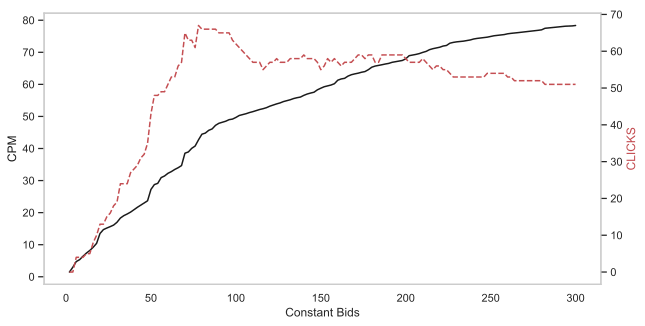

In [61]:
fig, ax1 = plt.subplots()
ax1.plot(const_df['constant_bids'].astype(float),const_df['cpm'].astype(float),color='k')
ax1.set_xlabel('Constant Bids')
ax1.set_ylabel('CPM', color='k')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(const_df['constant_bids'].astype(float), const_df['clicks'].astype(float),color='r',linestyle='--')
ax2.set_ylabel('CLICKS', color='r')
ax2.grid(False)
fig.set_size_inches(10, 5)

# fig.savefig('constant.PNG', dpi=200)

plt.show()

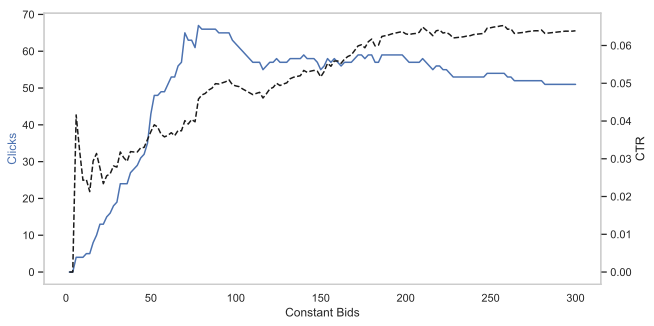

In [62]:
fig, ax1 = plt.subplots()
ax1.plot(const_df['constant_bids'].astype(float),const_df['clicks'].astype(float))
ax1.set_xlabel('Constant Bids')
ax1.set_ylabel('Clicks', color='b')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(const_df['constant_bids'].astype(float), const_df['ctr'].astype(float),color='k',linestyle='--')
ax2.set_ylabel('CTR', color='k')
ax2.grid(False)
fig.set_size_inches(10, 5)

# fig.savefig('constant.PNG', dpi=200)

plt.show()

In [11]:
winning_bid_ctr = const_df[const_df['ctr'] == max(const_df['ctr'])]
winning_bid_ctr

,constant_bids,impression_won,clicks,ctr,total_spend,cpm,cpc
128,258,82750,54,0.0653,6249.999,75.53,115.74


In [64]:
winning_bid_clicks = const_df[const_df['clicks'] == max(const_df['clicks'])]
winning_bid_clicks

,constant_bids,impression_won,clicks,ctr,total_spend,cpm,cpc
38,78,146338,67,0.0458,6249.999,42.71,93.28


#### Comments :

### Part 2 - Random Bidding

In [41]:
%%time
m = 30
bid_range = np.arange(min_bid, max_bid-m, 1)
upper_bound = []
lower_bound = []
impression_list = []
clicks_list = []
cost_list = []
for i in range(1,501):
    rnd = random.choice(bid_range)
    lower_bound.append(rnd)
    upper_bound.append(rnd+m)
    i_list = []
    cl_list = []
    c_list = []
    for j in range(rnd,rnd+m,2):
        [impressions, clicks, costs] = random_bids(j)
        i_list.append(impressions)
        cl_list.append(clicks)
        c_list.append(costs)
    impression_list.append(sum(i_list)/len(i_list))
    clicks_list.append(sum(cl_list)/len(cl_list))
    cost_list.append(sum(c_list)/len(c_list))

Wall time: 45min 20s


In [42]:
rand_df = pd.DataFrame()
rand_df = bounds(rand_df,lower_bound,upper_bound)

rand_df = calc_impression(rand_df,impression_list)
rand_df = calc_clicks(rand_df,clicks_list)
rand_df = calc_costs(rand_df,cost_list)

In [43]:
rand_df

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
0,82,112,128544,62.933333,0.049,6249.999000,48.62,99.31
1,250,280,82277,52.800000,0.0642,6249.999000,75.96,118.37
2,205,235,87477,55.200000,0.0631,6249.999000,71.45,113.22
3,76,106,133472,64.266667,0.0481,6249.999000,46.83,97.25
4,121,151,112185,57.466667,0.0512,6249.999000,55.71,108.76
5,189,219,90937,57.600000,0.0633,6249.999000,68.73,108.51
6,115,145,114324,57.333333,0.0501,6249.999000,54.67,109.01
7,145,175,103095,57.333333,0.0556,6249.999000,60.62,109.01
8,202,232,88030,55.733333,0.0633,6249.999000,71.0,112.14
9,125,155,110686,57.400000,0.0519,6249.999000,56.47,108.88


In [459]:
winning_bid_clicks

,constant_bids,impression_won,clicks,ctr,total_spend,cpm,cpc
38,78,146338,67,0.0458,6249.999,42.71,93.28


In [469]:
best_bound_clicks = rand_df[rand_df['clicks'] == max(rand_df['clicks'])]
best_bound_clicks

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
304,77,87,141592,67.0,0.0473,6249.999,44.14,93.28


In [460]:
winning_bid_ctr

,constant_bids,impression_won,clicks,ctr,total_spend,cpm,cpc
128,258,82750,54,0.0653,6249.999,75.53,115.74


In [44]:
best_bound_ctr = rand_df[rand_df['ctr'] == max(rand_df['ctr'])]
best_bound_ctr

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
32,249,279,82367,52.933333,0.0643,6249.999,75.88,118.07
46,249,279,82367,52.933333,0.0643,6249.999,75.88,118.07
149,249,279,82367,52.933333,0.0643,6249.999,75.88,118.07
449,249,279,82367,52.933333,0.0643,6249.999,75.88,118.07


#### Comments:

### Part 3 - Random Bidding with  Competitions

Takes Very Very Long to Run.

In [13]:
%%time
m = 30
n = 50
bid_range = np.arange(min_bid, max_bid-m, 1)
comp_bid = np.arange(min_bid, max_bid-m, 1)
upper_bound = []
lower_bound = []
impression_list = []
clicks_list = []
cost_list = []
for i in range(1,501):
    rnd = random.choice(bid_range)
    compt = random.sample(range(min_bid, max_bid-m), n)
    lower_bound.append(rnd)
    upper_bound.append(rnd+m)
    i_list = []
    cl_list = []
    c_list = []
    for j in range(rnd,rnd+m,1):
        [impressions, clicks, costs] = competitor_bids(j,compt)
        i_list.append(impressions)
        cl_list.append(clicks)
        c_list.append(costs)
    impression_list.append(sum(i_list)/len(i_list))
    clicks_list.append(sum(cl_list)/len(cl_list))
    cost_list.append(sum(c_list)/len(c_list))

Wall time: 2h 44min 40s


In [14]:
comp_df = pd.DataFrame()
comp_df = bounds(comp_df,lower_bound,upper_bound)

comp_df = calc_impression(comp_df,impression_list)
comp_df = calc_clicks(comp_df,clicks_list)
comp_df = calc_costs(comp_df,cost_list)

In [15]:
comp_df

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
0,46,76,0,0.000000,nan,0.000000,nan,nan
1,84,114,0,0.000000,nan,0.000000,nan,nan
2,145,175,0,0.000000,nan,0.000000,nan,nan
3,230,260,0,0.000000,nan,0.000000,nan,nan
4,10,40,0,0.000000,nan,0.000000,nan,nan
5,198,228,0,0.000000,nan,0.000000,nan,nan
6,26,56,0,0.000000,nan,0.000000,nan,nan
7,256,286,14879,8.866667,0.0596,3958.426700,266.04,446.44
8,2,32,0,0.000000,nan,0.000000,nan,nan
9,84,114,0,0.000000,nan,0.000000,nan,nan


In [16]:
# best_bound2_ctr = comp_df[(comp_df['ctr'] == max(comp_df['ctr'])) & (comp_df['ctr'] != 'nan')]
best_bound2_ctr = comp_df[(comp_df['ctr'] != 'nan')]
best_bound2_ctr[(best_bound2_ctr['ctr'] == max(best_bound2_ctr['ctr']))]

,lower_bound,upper_bound,impression_won,clicks,ctr,total_spend,cpm,cpc
62,265,295,19359,11.666667,0.0603,5208.460400,269.05,446.44
102,260,290,15488,9.333333,0.0603,4166.765000,269.03,446.44
248,268,298,21681,13.066667,0.0603,5833.472667,269.06,446.44
258,248,278,6195,3.733333,0.0603,1666.698933,269.04,446.44
440,260,290,15488,9.333333,0.0603,4166.765000,269.03,446.44


# Taking approach of experimenting on Training Set

### Part 1 : Constant Bidding Strategy

In [7]:
## Evaluate Strategy according to Metrices

def bidstrat_eval(bids, df, budget):

    cost = 0
    impressions = 0
    clicks = 0
    N = len(df)

    for i in range(0, N):
        bidid = df.bidid.values[i]
        actual_bidprice = df.bidprice.values[i] / 1000
        pay_price = df.payprice.values[i] / 1000
        clk = df.click.values[i]
        bid_price = bids[bidid] / 1000        
        if cost+bid_price <= budget and pay_price < bid_price:
            cost += pay_price
            impressions += 1
            if clk == 1:
                clicks += 1
    if impressions > 0:
        ctr = round((clicks / impressions) * 100,4)  ## in %
        cpm = round(cost / impressions * 1000,2)
    else:
        ctr = 0
        cpm = 0
    if clicks > 0:
        cpc = (cost / clicks).round(2)
    else:
        cpc = 0

    return round(cost,2), int(impressions), cpm, int(clicks), ctr, cpc

In [18]:
def const_train(train_df, lower_bid=2, upper_bid=302, bid_inc=2):
    print('Train Constant Bidding Strategy Model:')
    print('--------------------------------------')
    print('(CTR, Optimal Constant Bid, CPC)')
    
    df = train_df 
#     adv_id = list(set(df['advertiser']))

#     n = len(adv_id) * len(range(lower_bid, upper_bid, bid_inc))

    optimal_const_bidprice = []
    optimal_const_bid = {}

#     for i in adv_id:
    top_ctr = (0, 0, 1)  # tuple containing highest ctr and corresponding bid prices
    for j in range(lower_bid, upper_bid, bid_inc):
        lines = df[(df['bidprice'] <= j)]
        imps = len(lines)  # no. of impressions
        clicks = len(lines[lines['click']==1])
        cost = sum(lines.payprice.values)
        if imps > 0:
            ctr = clicks / imps  # click through rate
            cpc = cost / clicks # cost per click
        else:
            ctr = 0
            cpc = 1
        if (ctr > 0) and (ctr / cpc) > (top_ctr[0] / top_ctr[2]):
            top_ctr = (ctr, j, cpc)
    optimal_const_bidprice.append(top_ctr)
    optimal_const_bid["top_ctr"] = top_ctr[1]

    for optimal_const_bidprice in optimal_const_bidprice:
        print(optimal_const_bidprice)
    
    return optimal_const_bid


def const_predict(const_bidprices, validation_df):

    pred_bids = {}
    df = val_df
    N = len(df)

    for i in range(0, N):
        bidid = df.bidid.values[i]
        adv_id = df.advertiser.values[i]
        const_bidprice = const_bidprices[adv_id]
        pred_bids[bidid] = const_bidprice

    return pred_bids

In [8]:
def const_train(train_df, lower_bid=2, upper_bid=400, bid_inc=2):
    print('Train Constant Bidding Strategy Model:')
    print('--------------------------------------')
    print('(adv_id, CTR, Optimal Constant Bid, CPC)')
    
    df = train_df 
    adv_id = list(set(df['advertiser']))

    n = len(adv_id) * len(range(lower_bid, upper_bid, bid_inc))

    optimal_const_bidprice = []
    optimal_const_bid = {}

    for i in adv_id:
        top_ctr = (i, 0, 0, 1)  # tuple containing highest ctr and corresponding bid prices
        for j in range(lower_bid, upper_bid, bid_inc):
            lines = df[(df['advertiser'] == i) & (df['bidprice'] <= j)]
            imps = len(lines)  # no. of impressions
            clicks = len(lines[lines['click']==1])
            cost = sum(lines.payprice.values)
            if imps > 0:
                ctr = clicks / imps  # click through rate
                cpc = cost / clicks # cost per click
            else:
                ctr = 0
                cpc = 1
            if (ctr > 0) and (ctr / cpc) > (top_ctr[1] / top_ctr[3]):
                top_ctr = (i, ctr, j, cpc)
        optimal_const_bidprice.append(top_ctr)
        optimal_const_bid[i] = top_ctr[2]

    for optimal_const_bidprice in optimal_const_bidprice:
        print(optimal_const_bidprice)
    
    return optimal_const_bid


def const_predict(const_bidprices, validation_df):

    pred_bids = {}
    df = val_df
    N = len(df)

    for i in range(0, N):
        bidid = df.bidid.values[i]
        adv_id = df.advertiser.values[i]
        const_bidprice = const_bidprices[adv_id]
        pred_bids[bidid] = const_bidprice

    return pred_bids

In [19]:
%%time

const_bidprices = const_train(train_df)
# const_bids = const_predict(const_bidprices, val_df)
# winning_bidder = bidstrat_eval(const_bids, val_df, 6250)

Train Constant Bidding Strategy Model:
--------------------------------------
(CTR, Optimal Constant Bid, CPC)
(0.000928883177034954, 228, 101085.30136986301)
Wall time: 27.6 s


In [9]:
%%time

const_bidprices = const_train(train_df)
const_bids = const_predict(const_bidprices, val_df)
winning_bidder = bidstrat_eval(const_bids, val_df, 6250)

Train Constant Bidding Strategy Model:
--------------------------------------
(adv_id, CTR, Optimal Constant Bid, CPC)
(3427, 0.0009797198001371607, 228, 93153.12)
(2821, 0.0006197780153856344, 294, 143725.52671755725)
(1458, 0.0007819592853095239, 300, 88230.48311688312)
(2259, 0.0003216805188781579, 294, 289028.79069767444)
(3476, 0.0006016053533225023, 254, 127907.90909090909)
(2261, 0.0003530272083112691, 278, 226217.2857142857)
(2997, 0.0043548937365791, 278, 14420.585253456222)
(3386, 0.0007032333350181632, 300, 109161.946875)
(3358, 0.0008900723277261269, 228, 107751.0)
Wall time: 3min 45s


In [10]:
const_bidprices

{3427: 228,
 2821: 294,
 1458: 300,
 2259: 294,
 3476: 254,
 2261: 278,
 2997: 278,
 3386: 300,
 3358: 228}

In [663]:
winning_bid = pd.DataFrame(list(winning_bidder), index=['Spend','Impression','CPM','Clicks','CTR(%)','CPC'])
winning_bid = winning_bid.T
winning_bid

,Spend,Impression,CPM,Clicks,CTR(%),CPC
0,6249.86,80149.0,77.98,51.0,0.0636,122.55


In [650]:
winning_bid = pd.DataFrame(list(winning_bidder), index=['Spend','Impression','CPM','Clicks','CTR(%)','CPC'])
winning_bid = winning_bid.T
winning_bid

,Spend,Impression,CPM,Clicks,CTR(%),CPC
0,6249.82,76831.0,81.35,49.0,0.0638,127.55


### Part 2 : Random Bidding Strategy

In [673]:
def rand_train(train_df):
    print('Training Random Bidding Strategy Model:')
    print('---------------------------------------')
#     print('(adv_id, CTR, Optimal Constant Bid, CPC)')
    
    df = train_df
    adv_id = list(set(df['advertiser']))
    N = len(adv_id)

    adv_bidrange = {}

    for i in adv_id:
        
        lines = df[(df.advertiser == i)]
        bidprices = lines.bidprice.values
        min_bidprice = min(bidprices)
        max_bidprice = max(bidprices)
        adv_bidrange[i] = (min_bidprice, max_bidprice)

    for j in adv_bidrange:
        print(j, adv_bidrange[j])

    return adv_bidrange


def rand_predict(adv_bidrange, val_df):
   
    pred_bids = {}
    df = val_df

    N = len(df)

    for i in range(0, N):
        bidid = df.bidid.values[i]
        adv_id = df.advertiser.values[i]
        min_bidprice = adv_bidrange[adv_id][0]
        max_bidprice = adv_bidrange[adv_id][1]
        diff = max_bidprice - min_bidprice
        rand_bidprice = random.randint(min_bidprice, max_bidprice+diff)
        pred_bids[bidid] = rand_bidprice

    return pred_bids

In [674]:
%%time
adv_bidrange = rand_train(train_df)
rand_bids = rand_predict(adv_bidrange, val_df)
winning_range = bidstrat_eval(rand_bids, val_df, 6250)

Training Random Bidding Strategy Model:
---------------------------------------
3427 (227, 241)
2821 (277, 294)
1458 (300, 300)
2259 (277, 294)
3476 (238, 254)
2261 (277, 294)
2997 (277, 277)
3386 (300, 300)
3358 (227, 241)
Wall time: 13 s


In [675]:
winning_range = pd.DataFrame(list(winning_range), index=['Spend','Impression','CPM','Clicks','CTR(%)','CPC'])
winning_bounds = winning_range.T
winning_bounds

,Spend,Impression,CPM,Clicks,CTR(%),CPC
0,6249.85,80099.0,78.03,51.0,0.0637,122.55


In [672]:
winning_bid

,Spend,Impression,CPM,Clicks,CTR(%),CPC
0,6249.86,80149.0,77.98,51.0,0.0636,122.55


In [545]:
train_df[train_df['advertiser'] == 3386]

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
6,0,3,12,6b4f23dd215a5f11136c2f29214236cfee1f0122,fbd1bcaf2b33108d2c7f88ac41f0b0194b508a9b,windows_ie,112.82.93.*,80,89,3.0,3FKElpuEMusyJqKbuKz,6957deb8d83340086ef3cb2abd9c7198,NaN,Fashion_F_Width1,1000,90,0,0,20,86c2543527c86a893d4d4f68810a0416,300,20,43f4a37f42a7c5e6219e2601b26c6976,3386,"10083,10024,10063,13496,10093,10006,10057,10110"
15,0,0,2,f6960768ba29f2d6c23427d018020d6964680904,9fc09005c687b9b22e55a054daf5ad2e60c1f3f3,windows_ie,122.198.132.*,1,1,3.0,3SCYZrn0Qo18XMB4JKTI,613346daf7f86e4e7db34affe4d8753e,NaN,discuz_18316225_004,728,90,0,0,20,b90c12ed2bd7950c6027bf9c6937c48a,300,20,43f4a37f42a7c5e6219e2601b26c6976,3386,NaN
19,0,4,20,2463f4c6b733b78a57ba238b0ff01906041208ff,e8202670ea64861279f99933d694ed716e1660af,windows_chrome,125.66.211.*,276,279,3.0,ersbQv1RdoTy1m58uG,5ca4edd8c9b82f26f5619daaa52982a2,NaN,ALLINONE_F_Width1,1000,90,0,0,70,86c2543527c86a893d4d4f68810a0416,300,70,43f4a37f42a7c5e6219e2601b26c6976,3386,"10083,14273,13403,10063,10006,10110"
22,0,2,17,60961a2eeb0e887aa4d0e4e414cfc879c8228edb,7d8c4118d6700b456625274325188d286288b570,mac_other,14.154.138.*,216,219,1.0,5dxSTuxYLelf1m58uG,72adbec43b8d2034491c4cafe139de2f,NaN,mm_22772635_2427241_9847948,300,250,2,1,0,44966cc8da1ed40c95d59e863c8c75f0,300,78,361e128affece850342293213691a043,3386,NaN
23,0,2,14,1da6adb65d619d9c7bcc86d6a82422641a176d34,4ef40b901663d20ac2ff78d2e2f672bda784f8f4,windows_ie,218.78.197.*,79,79,3.0,3FF-e59aG5syJqKbuKz,bcdcfac8493d430741f76c5d23e8faa8,NaN,ALLINONE_F_Width1,1000,90,0,0,70,86c2543527c86a893d4d4f68810a0416,300,70,43f4a37f42a7c5e6219e2601b26c6976,3386,"10063,13403,10083,10057,10077,10006,10024,10110"
30,0,0,16,3da0ae375ae794d4c8a373c281f87afbb8cd7bcd,48633cf5cdb80df9a41c4378cfe37e4fbf5b05d1,windows_ie,27.227.147.*,344,345,3.0,3FF-e59aG5syJqKbuKz,73c29bcfbf34c69d839c7223e04eb006,NaN,tips_F_Width2,1000,90,0,0,50,86c2543527c86a893d4d4f68810a0416,300,64,43f4a37f42a7c5e6219e2601b26c6976,3386,"10063,10006,10111"
36,0,4,20,05b59cf4811395d42d48926b3c1464bd15b6dc2c,9d95d0fbbb3d6784e910b8e145d60f1ba049a9e0,windows_chrome,27.197.194.*,146,159,3.0,ersbQv1RdoTy1m58uG,36c381d7a4361ce65c044a600a85bfac,NaN,ALLINONE_F_Width1,1000,90,0,0,70,86c2543527c86a893d4d4f68810a0416,300,70,43f4a37f42a7c5e6219e2601b26c6976,3386,NaN
37,0,4,19,87c3f7f641c0d543146162ee879ffd60460fa866,bcddc7d9b779095ac8989a0e73028cc6c2cc7080,windows_chrome,60.182.124.*,94,101,3.0,5F1RQS9rg5scFsf,23e01ec66c6a9b59fe621acaa9a1e979,NaN,tips_F_Width1,1000,90,0,0,70,86c2543527c86a893d4d4f68810a0416,300,70,43f4a37f42a7c5e6219e2601b26c6976,3386,10006
48,0,2,14,347b7e166a81cc862c38edd7b784dd4b3089b631,cdccfd3a7ea21e5196c82a5dc2ac5dcc7b4d9d7d,windows_ie,110.228.157.*,3,4,2.0,DF1gGe1IdoNsFddmcMpENpn,5524ebe129f90f1a671f4342153a12cc,NaN,2364196306,300,250,2,0,5,44966cc8da1ed40c95d59e863c8c75f0,300,42,361e128affece850342293213691a043,3386,"10048,10006,10063,13866,11092,10684,10111"
49,0,6,19,7bb6aa8e749f2751ce5520f04c88ca6a6bc78ef5,9b20595d703289370bae493ea8e37bbb2ca1b310,windows_chrome,175.149.63.*,40,47,3.0,31xSTvprdN1RFt,576342ab95aab69f4f12c2e460b2cda1,NaN,Ent_F_Upright,300,250,0,0,50,44966cc8da1ed40c95d59e863c8c75f0,300,50,43f4a37f42a7c5e6219e2601b26c6976,3386,"10063,10006,10111"


In [541]:
list(set(train_df.payprice[train_df['advertiser'] == 3386]))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
